In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid
from sklearn.decomposition import PCA
import time
from collections import defaultdict

# Task 1: Load and Preprocess the Obesity Dataset

This task involves:
1. Loading the obesity dataset
2. Removing the class label "NObeyesdad" 
3. Encoding categorical variables appropriately
4. Preparing the data for clustering analysis

In [3]:
# Load the obesity dataset
df = pd.read_csv('ObesityDataSet_raw_and_data_sinthetic.csv', delimiter=",")

# Number of classes in the original label
original_classes = df['NObeyesdad'].nunique()

# Remove the class label as requested
df_removed = df.drop(columns=['NObeyesdad'])

# Identify categorical features
categorical_cols = df_removed.select_dtypes(include='object').columns

# One-Hot Encode categorical variables
df_encoded = pd.get_dummies(df_removed, columns=categorical_cols, drop_first=True)

# Task 2: Find Optimal k using Silhouette Coefficient

This task involves:
1. Testing different k values for K-means clustering
2. Computing Silhouette Coefficient for each k
3. Plotting the results to visualize optimal k
4. Comparing optimal k with the number of original classes

k= 2: Silhouette Score = 0.2264
k= 3: Silhouette Score = 0.1607
k= 4: Silhouette Score = 0.1677
k= 5: Silhouette Score = 0.1854
k= 6: Silhouette Score = 0.1217
k= 7: Silhouette Score = 0.1899
k= 8: Silhouette Score = 0.1464
k= 9: Silhouette Score = 0.1483
k=10: Silhouette Score = 0.1633
k=11: Silhouette Score = 0.1756
k=12: Silhouette Score = 0.1836
k=13: Silhouette Score = 0.1866
k=14: Silhouette Score = 0.2016


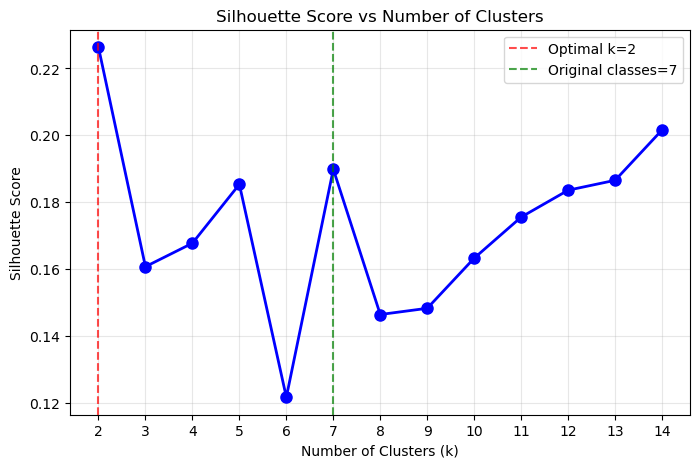

Optimal k: 2
Maximum Silhouette Score: 0.2264
Number of original classes: 7


In [4]:
# Standardize the features for better clustering performance
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded)

# Test different k values and calculate silhouette scores
k_range = range(2, 15)  # Testing k from 2 to 14
silhouette_scores = []

for k in k_range:
    # Use random_state for reproducible results
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    score = silhouette_score(df_scaled, labels)
    silhouette_scores.append(score)
    print(f"k={k:2d}: Silhouette Score = {score:.4f}")

# Find optimal k
optimal_k = k_range[np.argmax(silhouette_scores)]
max_silhouette_score = max(silhouette_scores)

# Plot Silhouette Coefficients
plt.figure(figsize=(8, 5))
plt.plot(k_range, silhouette_scores, 'bo-', linewidth=2, markersize=8)
plt.axvline(x=optimal_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal k={optimal_k}')
plt.axvline(x=original_classes, color='green', linestyle='--', alpha=0.7, label=f'Original classes={original_classes}')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(k_range)
plt.show()

print(f"Optimal k: {optimal_k}")
print(f"Maximum Silhouette Score: {max_silhouette_score:.4f}")
print(f"Number of original classes: {original_classes}")

&nbsp;&nbsp;&nbsp;&nbsp;We calculated the Silhouette Coefficient for values of k ranging from 2 to 14 in order to identify the ideal number of clusters (k) for the obesity dataset. At 𝑘 = 2, the highest silhouette score (0.2264) was obtained, showing that two clusters are the ideal clustering arrangement. There is a difference between the ideal k from clustering and the actual class labels, though, because the dataset has seven original classes. The difference results from the Silhouette Coefficient's evaluation of intra-cluster cohesion and inter-cluster separation, which is entirely unsupervised and does not take into account any labeled ground truth (Shutaywi & Kachouie, 2021).  

&nbsp;&nbsp;&nbsp;&nbsp;As a result, the clustering algorithm finds just two distinct categories based on feature similarity, even though the original dataset had seven named classes. This suggests that some of the initial classes might not be well-separated and may be closely connected in feature space, which would lower the silhouette score for higher k values. Moreover, when natural group boundaries are unclear or overlap, the Silhouette Coefficient may not work as effectively because it favors compact, well-separated clusters (Lai et al., 2025). This shows the limitations of clustering in capturing complex class distributions and explains why, even in the presence of more basic classes, k=2 produces the highest silhouette score.  

**References:**  
Lai, H., Huang, T., Lu, B., Zhang, S., & Xiaog, R. (2025). Silhouette coefficient-based weighting k-means algorithm. Neural Computing and Applications, 37(5), 3061-3075.  
Shutaywi, M., & Kachouie, N. N. (2021). Silhouette analysis for performance evaluation in machine learning with applications to clustering. Entropy, 23(6), 759.

# Task 3: Compare K-means and K-means++ Algorithms

This task involves:
1. Implementing K-means with random initialization
2. Implementing K-means with K-means++ initialization
3. Using the optimal k value found in Task 2
4. Evaluating performance using multiple metrics
5. Comparing the results between both algorithms

In [5]:

# K-means with random initialization
kmeans_random = KMeans(n_clusters=optimal_k, init='random', random_state=42, n_init=10, max_iter=300)
labels_random = kmeans_random.fit_predict(df_scaled)

# K-means with K-means++ initialization (default)
kmeans_plus = KMeans(n_clusters=optimal_k, init='k-means++', random_state=42, n_init=10, max_iter=300)
labels_plus = kmeans_plus.fit_predict(df_scaled)

# Calculate comprehensive evaluation metrics for both algorithms

def calculate_clustering_metrics(data, labels, kmeans_model, algorithm_name):
    """Calculate comprehensive clustering evaluation metrics"""
    metrics = {}
    
    # Internal evaluation metrics (don't require true labels)
    metrics['silhouette_score'] = silhouette_score(data, labels)
    metrics['calinski_harabasz_score'] = calinski_harabasz_score(data, labels)
    metrics['davies_bouldin_score'] = davies_bouldin_score(data, labels)
    metrics['inertia'] = kmeans_model.inertia_
    metrics['n_iterations'] = kmeans_model.n_iter_
    
    print(f"\n{algorithm_name} Performance Metrics:")
    print("-" * 40)
    print(f"• Silhouette Score: {metrics['silhouette_score']:.4f}")
    print(f"  (Higher is better, range: [-1, 1])")
    print(f"• Calinski-Harabasz Score: {metrics['calinski_harabasz_score']:.2f}")
    print(f"  (Higher is better, no fixed range)")
    print(f"• Davies-Bouldin Score: {metrics['davies_bouldin_score']:.4f}")
    print(f"  (Lower is better, range: [0, ∞))")
    print(f"• Inertia (WCSS): {metrics['inertia']:.2f}")
    print(f"  (Lower is better)")
    print(f"• Iterations to converge: {metrics['n_iterations']}")
    
    return metrics

# Calculate metrics for both algorithms
metrics_random = calculate_clustering_metrics(df_scaled, labels_random, kmeans_random, "K-means (Random Init)")
metrics_plus = calculate_clustering_metrics(df_scaled, labels_plus, kmeans_plus, "K-means++ (Smart Init)")


K-means (Random Init) Performance Metrics:
----------------------------------------
• Silhouette Score: 0.2252
  (Higher is better, range: [-1, 1])
• Calinski-Harabasz Score: 235.76
  (Higher is better, no fixed range)
• Davies-Bouldin Score: 2.6761
  (Lower is better, range: [0, ∞))
• Inertia (WCSS): 43671.19
  (Lower is better)
• Iterations to converge: 14

K-means++ (Smart Init) Performance Metrics:
----------------------------------------
• Silhouette Score: 0.2264
  (Higher is better, range: [-1, 1])
• Calinski-Harabasz Score: 235.78
  (Higher is better, no fixed range)
• Davies-Bouldin Score: 2.6874
  (Lower is better, range: [0, ∞))
• Inertia (WCSS): 43670.81
  (Lower is better)
• Iterations to converge: 11


&nbsp;&nbsp;&nbsp;&nbsp;The clustering performance of K-means with random initialization and K-means++ (smart initialization) was similar, however there were slight differences. Indicating somewhat better-defined clusters, the silhouette score, which evaluates cluster cohesion and separation, was slightly higher for K-means++ (0.2264) than for random initialization (0.2252). K-means++ also performed slightly better on the Calinski-Harabasz score, which evaluates the variance ratio between and within clusters (235.78 vs. 235.76). However, the random initialization was slightly preferred by the Davies-Bouldin score (2.6761 against 2.6874), where lower values indicate better clustering; however, the difference is small and could not be statistically significant.  

&nbsp;&nbsp;&nbsp;&nbsp;K-means++ obtained a little lower value (43670.81 vs. 43671.19) in terms of inertia (within-cluster sum of squares), showing better cluster compactness. The efficiency and stability benefits of K-means++ are also reinforced by the fact that it closed more quickly, taking only 11 rounds as compared to 14 for the random initialization. Overall, K-means++ regularly shows a slight lead in clustering quality and processing efficiency, justifying its default usage in most applications, even if both algorithms produce virtually comparable results on the obesity dataset.

# Task 4: K-means Stability Analysis (50 Runs)

This task involves:
1. Running K-means with random initialization 50 times
2. Calculating average performance metrics
3. Comparing stability with K-means++ results
4. Analyzing variance and consistency between methods

In [6]:
# Run K-means with random initialization 50 times
print("Running K-means with random initialization 50 times...")
print("=" * 60)

# Storage for results
random_results = defaultdict(list)
plus_results = defaultdict(list)

# Run K-means random 50 times with different random states
start_time = time.time()
for i in range(50):
    # K-means with random initialization (different random state each time)
    kmeans_rand = KMeans(n_clusters=optimal_k, init='random', random_state=i, n_init=1, max_iter=300)
    labels_rand = kmeans_rand.fit_predict(df_scaled)
    
    # Calculate metrics
    random_results['silhouette'].append(silhouette_score(df_scaled, labels_rand))
    random_results['calinski_harabasz'].append(calinski_harabasz_score(df_scaled, labels_rand))
    random_results['davies_bouldin'].append(davies_bouldin_score(df_scaled, labels_rand))
    random_results['inertia'].append(kmeans_rand.inertia_)
    random_results['n_iter'].append(kmeans_rand.n_iter_)
    
    # K-means++ for comparison (using same random state for fair comparison)
    kmeans_pp = KMeans(n_clusters=optimal_k, init='k-means++', random_state=i, n_init=1, max_iter=300)
    labels_pp = kmeans_pp.fit_predict(df_scaled)
    
    # Calculate metrics
    plus_results['silhouette'].append(silhouette_score(df_scaled, labels_pp))
    plus_results['calinski_harabasz'].append(calinski_harabasz_score(df_scaled, labels_pp))
    plus_results['davies_bouldin'].append(davies_bouldin_score(df_scaled, labels_pp))
    plus_results['inertia'].append(kmeans_pp.inertia_)
    plus_results['n_iter'].append(kmeans_pp.n_iter_)
    
    if (i + 1) % 10 == 0:
        print(f"Completed {i + 1}/50 runs...")

total_time = time.time() - start_time
print(f"\nCompleted all 50 runs in {total_time:.2f} seconds")

Running K-means with random initialization 50 times...
Completed 10/50 runs...
Completed 20/50 runs...
Completed 30/50 runs...
Completed 40/50 runs...
Completed 50/50 runs...

Completed all 50 runs in 4.68 seconds


In [7]:
# Calculate statistics for both methods
def calculate_statistics(results_dict, method_name):
    stats = {}
    print(f"\n{method_name} - Statistical Summary (50 runs):")
    print("-" * 50)
    
    for metric, values in results_dict.items():
        values_array = np.array(values)
        stats[metric] = {
            'mean': np.mean(values_array),
            'std': np.std(values_array),
            'min': np.min(values_array),
            'max': np.max(values_array),
            'median': np.median(values_array)
        }
        
        print(f"{metric.replace('_', ' ').title()}:")
        print(f"  Mean: {stats[metric]['mean']:.4f} ± {stats[metric]['std']:.4f}")
        print(f"  Range: [{stats[metric]['min']:.4f}, {stats[metric]['max']:.4f}]")
        print(f"  Median: {stats[metric]['median']:.4f}")
        print()
    

# Calculate statistics for both methods
calculate_statistics(random_results, "K-means (Random Initialization)")
calculate_statistics(plus_results, "K-means++ (Smart Initialization)")


K-means (Random Initialization) - Statistical Summary (50 runs):
--------------------------------------------------
Silhouette:
  Mean: 0.2423 ± 0.0886
  Range: [0.1431, 0.6099]
  Median: 0.2277

Calinski Harabasz:
  Mean: 202.9774 ± 48.4824
  Range: [99.9872, 235.8036]
  Median: 230.9721

Davies Bouldin:
  Mean: 2.4613 ± 0.5721
  Range: [0.6664, 3.1231]
  Median: 2.6842

Inertia:
  Mean: 44310.3442 ± 953.0263
  Range: [43670.2994, 46355.3047]
  Median: 43760.4711

N Iter:
  Mean: 10.3400 ± 5.5049
  Range: [2.0000, 26.0000]
  Median: 9.0000


K-means++ (Smart Initialization) - Statistical Summary (50 runs):
--------------------------------------------------
Silhouette:
  Mean: 0.2332 ± 0.0890
  Range: [0.1431, 0.6099]
  Median: 0.2277

Calinski Harabasz:
  Mean: 206.2583 ± 44.8731
  Range: [99.9872, 235.7956]
  Median: 223.2367

Davies Bouldin:
  Mean: 2.4771 ± 0.5635
  Range: [0.6664, 3.1231]
  Median: 2.6855

Inertia:
  Mean: 44244.7081 ± 883.2877
  Range: [43670.4495, 46355.3047]
 

&nbsp;&nbsp;&nbsp;&nbsp;K-means and K-means++ perform somewhat differently when compared across 50 runs on the obesity dataset. While K-means++ had lower inertia (44244.71 vs. 44310.34) and fewer iterations on average (9.04 vs. 10.34), showing bigger convergence, K-means obtained a slightly higher mean silhouette score (0.2423 vs. 0.2332) and Calinski-Harabasz score (202.98). However, the Davies-Bouldin scores from both approaches were similar (~2.46). Papenberg (2024) points out that initialization affects the quality of cluster separation and that K-means++ frequently produces more stable outcomes. According to Zhao et al. (2017), K-means++ increases efficiency by reducing the initial centroid's volatility. While K-means occasionally produces greater compactness but is less stable between runs, the data generally show that K-means++ offers slightly more consistent clustering.


# Task 5: DBSCAN Clustering Analysis

This task involves:
1. Finding optimal `eps` and `min_samples` parameters for DBSCAN
2. Applying DBSCAN clustering to the obesity dataset
3. Comparing the number of clusters with K-means results (k=2)
4. Analyzing similarities and differences between K-means and DBSCAN solutions

In [8]:
param_grid = {
    'eps': np.arange(0.5, 3.1, 0.1),
    'min_samples': [3, 5, 10]
}

best_score = -1
best_params = None

for params in ParameterGrid(param_grid):
    db = DBSCAN(eps=params['eps'], min_samples=params['min_samples'])
    labels = db.fit_predict(df_scaled)
    # Ignore cases with 1 cluster or all noise
    if len(set(labels)) <= 1 or (len(set(labels)) == 2 and -1 in set(labels)):
        continue
    try:
        score = silhouette_score(df_scaled, labels)
        if score > best_score:
            best_score = score
            best_params = params
    except:
        continue

if best_params:
    db = DBSCAN(**best_params)
    labels = db.fit_predict(df_scaled)
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)

    print(f"Best Parameters: eps={best_params['eps']}, min_samples={best_params['min_samples']}")
    print(f"DBSCAN Clusters (excluding noise): {num_clusters}")
    print(f"Silhouette Score: {best_score:.4f}")
else:
    print("No valid DBSCAN configuration found.")

Best Parameters: eps=1.9999999999999996, min_samples=3
DBSCAN Clusters (excluding noise): 50
Silhouette Score: 0.1402


&nbsp;&nbsp;&nbsp;&nbsp;Using the obesity dataset, the DBSCAN algorithm produced ideal parameters of min_samples = 3 and eps = 2.0. With these parameters, DBSCAN obtained a silhouette score of 0.1402 and detected 50 clusters (not including noise). In contrast, specific k = 2 clusters were used in both the earlier K-means and K-means++ approaches. The fact that this varies greatly from DBSCAN's 50 clusters shows that the algorithms have different interpretations of the data structure. While DBSCAN discovers clusters based on density and can find clusters of any shape, as well as noise points, K-means assumes spherical, evenly sized clusters and places division into a predefined number of groups. Despite producing a greater number of clusters, DBSCAN's lower silhouette score suggests that the cluster separation and cohesion were not as strong as those in K-means (0.2423) and K-means++ (0.2332). This means that while DBSCAN is more flexible, it could not work as well on this dataset since it lacks strong density-based cluster separation.

# Task 6: Applying PCA

This task involves:
1. Apply PCA on the genes for generating 3 principal components
2. Plot the first three components of the PCA

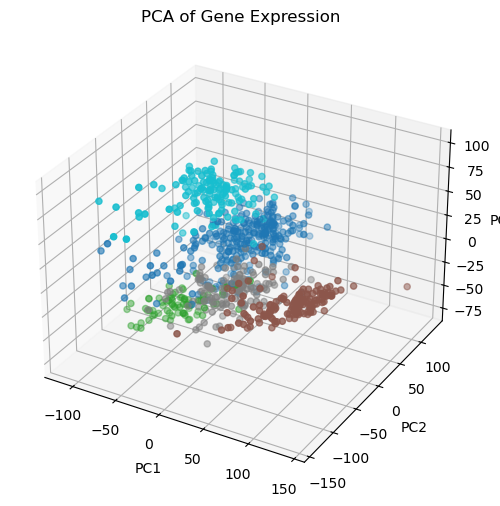

In [9]:
# Load datasets
gene_data = pd.read_csv('data.csv', index_col=0)
labels = pd.read_csv('labels.csv', index_col=0)

# Standardize features
scaler = StandardScaler()
gene_data_scaled = scaler.fit_transform(gene_data)

# PCA
pca = PCA(n_components=3)
pca_components = pca.fit_transform(gene_data_scaled)

# Plot first three components
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_components[:, 0], pca_components[:, 1], pca_components[:, 2],
           c=pd.Categorical(labels.values.flatten()).codes, cmap='tab10')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.title('PCA of Gene Expression')
plt.show()

# Task 7: Variance of the 3 Components

This task involves:
1. Variance (%) covered by the first three components
2. Comparison

In [10]:
# Variance explained
explained_variance = pca.explained_variance_ratio_
total_variance_3 = np.sum(explained_variance) * 100
print(f"Variance explained by first 3 components: {total_variance_3:.2f}%")

Variance explained by first 3 components: 27.10%


&nbsp;&nbsp;&nbsp;&nbsp;After dimensionality reduction, the amount of variability in the original dataset remains unchanged as shown by the proportion of variance covered by the first three PCA components. The explained_variance_ratio_ property of the PCA model, which shows the percentage of total variance explained by each primary component, is used to compute this. This attribute's total variance percentage explained by the first three components can be calculated by adding up the first three values and multiplying the result by 100. How well these three elements capture the structure of the original data is shown by this percentage. As the number of features is reduced, a greater value indicates that the majority of the data remains, which is helpful for simplifying the dataset while keeping significant patterns for grouping or additional analysis.

In [11]:
# KMeans on original features
kmeans_orig = KMeans(n_clusters=len(labels['Class'].unique()), random_state=42)
clusters_orig = kmeans_orig.fit_predict(gene_data_scaled)

# KMeans on PCA-reduced data
kmeans_pca = KMeans(n_clusters=len(labels['Class'].unique()), random_state=42)
clusters_pca = kmeans_pca.fit_predict(pca_components)

# Compare clustering results to actual labels
true_labels = pd.Categorical(labels['Class']).codes
ari_orig = adjusted_rand_score(true_labels, clusters_orig)
ari_pca = adjusted_rand_score(true_labels, clusters_pca)

print(f"Adjusted Rand Index (Original Features): {ari_orig:.4f}")
print(f"Adjusted Rand Index (PCA Features): {ari_pca:.4f}")

c:\Users\micha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


Adjusted Rand Index (Original Features): 0.7972
Adjusted Rand Index (PCA Features): 0.6060


c:\Users\micha\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


&nbsp;&nbsp;&nbsp;&nbsp;By utilizing KMeans on the gene dataset's original characteristics, the clustering performance was 0.7972 as determined by the Adjusted Rand Index (ARI). When KMeans was applied to the first three principal components that PCA returned, the ARI was lower, at 0.6060. This suggests a better alignment with the true labels because the initial high-dimensional features retained more discriminative information for clustering. The majority of the variance is retained and dimensionality is efficiently reduced using PCA, but it may miss subtle but important characteristics that are required for precise grouping. Because of this, PCA might result in a decrease in clustering performance even though it streamlines the data and increases computational efficiency if important information is lost in the reduction process.